In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split

import tqdm

import warnings

In [2]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [5]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min')
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.380444,0.180384,-1.712667,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,3.692009,0.254289,-1.369285,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.324900,0.247349,-1.396955,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.128645,0.048493,-3.026331,2650.599402,586308.612876,1718.061157,2650.599402,2650.599402,3.631836,51.036074,160.641345,4.32,583658.013474,1714.429321,2599.563327,2489.958056
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.271124,0.027434,-3.595966,2650.082079,586314.173248,1715.979046,2650.082079,2650.082079,3.704804,51.092926,160.489197,4.32,583664.091169,1712.274243,2598.989153,2489.592882


## TME implementation

### Data loaders

In [10]:
h = 3  # window length
batch_size = 64

# -----------------------------
df = df_merged.sort_values('datetime').reset_index(drop=True)
# STEP 1: Create time-of-day feature
df['time_of_day'] = df['datetime'].dt.strftime('%H:%M')

# -----------------------------
# STEP 2: Split indices (AFTER creating lags!)
n_total = len(df)
n_train = int(0.7 * n_total)
n_val = int(0.1 * n_total)

# -----------------------------
# STEP 3: Create deseasonalizing map using per-time volume means from train only
train_deseason_df = df.iloc[:n_train]
mean_volume_by_time = train_deseason_df.groupby('time_of_day')['total_volume'].mean()
df['mean_volume'] = df['time_of_day'].map(mean_volume_by_time)

df['deseasoned_total_volume'] = df['total_volume'] / df['mean_volume']
df['log_deseasoned_total_volume'] = np.log(df['deseasoned_total_volume'] + 1e-7)
df['target'] = df['deseasoned_total_volume'] + 1e-7

del train_deseason_df

# -----------------------------
# STEP 4: Define the source-specific features
source1_cols = ['buy_volume', 'sell_volume', 'buy_txn', 'sell_txn', 'volume_imbalance', 'txn_imbalance']
source2_cols = ['ask_volume', 'bid_volume', 'ask_slope_1', 'ask_slope_5', 'ask_slope_10', 'bid_slope_1', 'bid_slope_5', 'bid_slope_10', 'spread',
       'lob_volume_imbalance', 'slope_imbalance_1', 'slope_imbalance_5', 'slope_imbalance_10']
# target_col = 'log_deseasoned_total_volume'
target_col = 'target'
datetime_col = 'datetime'


# --- Create rolling windows efficiently ---
source1_array = df[source1_cols].values  # shape (N, F1)
source2_array = df[source2_cols].values  # shape (N, F2)
target_array = df[target_col].values  # shape (N,)
timestamps_array = df[datetime_col].values


# Create sliding windows ([:-1] in windows and [h:] in targets make sure the targets are matched with corresponding features)
source1_windows = sliding_window_view(source1_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F1, h)
source2_windows = sliding_window_view(source2_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F2, h)
y = target_array[h:]
timestamps = timestamps_array[h:]

# Convert to tensors
source1_tensor = torch.tensor(source1_windows, dtype=torch.float32)
source2_tensor = torch.tensor(source2_windows, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# --- Time-based split (preserving time order) ---
n_total = len(y_tensor)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

source1_train, source1_val, source1_test = source1_tensor[:n_train], source1_tensor[n_train:n_train + n_val], source1_tensor[n_train + n_val:]
source2_train, source2_val, source2_test = source2_tensor[:n_train], source2_tensor[n_train:n_train + n_val], source2_tensor[n_train + n_val:]
y_train, y_val, y_test = y_tensor[:n_train], y_tensor[n_train:n_train + n_val], y_tensor[n_train + n_val:]

# (Optional) timestamps split for tracking
timestamps_train = timestamps[:n_train]
timestamps_val = timestamps[n_train:n_train + n_val]
timestamps_test = timestamps[n_train + n_val:]

# Dataset ready for PyTorch training
train_dataset = torch.utils.data.TensorDataset(source1_train, source2_train, y_train)
val_dataset = torch.utils.data.TensorDataset(source1_val, source2_val, y_val)
test_dataset = torch.utils.data.TensorDataset(source1_test, source2_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### TME components 

In [11]:
class BilinearRegressor(nn.Module):
    def __init__(self, d, h, latent_variable):
        """
        d: number of features in the source data
        h: number of lags in the source data
        latent_variable (bool): if True the class is devoted for modeling latent variable z, if False => y|s_i
        """
        super().__init__()
        self.latent_variable = latent_variable

        # Mean parameters
        self.L_mu = nn.Parameter(torch.empty(d))
        self.R_mu = nn.Parameter(torch.empty(h))
        self.b_mu = nn.Parameter(torch.zeros(1))

        # Xavier init for 1D weight tensors
        nn.init.xavier_uniform_(self.L_mu.unsqueeze(0))
        nn.init.xavier_uniform_(self.R_mu.unsqueeze(0))

        if not self.latent_variable:
            self.L_sigma = nn.Parameter(torch.empty(d))
            self.R_sigma = nn.Parameter(torch.empty(h))
            self.b_sigma = nn.Parameter(torch.zeros(1))

            nn.init.xavier_uniform_(self.L_sigma.unsqueeze(0))
            nn.init.xavier_uniform_(self.R_sigma.unsqueeze(0))

    def forward(self, x):  # x: (B, d, h)
        mu = torch.einsum('bdh,d,h->b', x, self.L_mu, self.R_mu) + self.b_mu  # [B]
        if self.latent_variable:
            return mu
        log_var = torch.einsum('bdh,d,h->b', x, self.L_sigma, self.R_sigma) + self.b_sigma
        log_var = torch.clamp(log_var, min=-10, max=10)
        var = torch.exp(log_var)  # Ensure positivity
        return mu, var
    

class TME(nn.Module):
    def __init__(self, d1, d2, h):
        super().__init__()
        self.target1 = BilinearRegressor(d1, h, latent_variable=False)
        self.target2 = BilinearRegressor(d2, h, latent_variable=False)
        self.latent1 = BilinearRegressor(d1, h, latent_variable=True)
        self.latent2 = BilinearRegressor(d2, h, latent_variable=True)

    def forward(self, x1, x2, return_all=False):
        # x1: (B, d1, h), x2: (B, d2, h)
        mu1, var1 = self.target1(x1)  # [B], [B]
        mu2, var2 = self.target2(x2)

        logit1 = self.latent1(x1)
        logit2 = self.latent2(x2)

        logits = torch.stack([logit1, logit2], dim=1)  # [B, num_sources]
        probs = F.softmax(logits, dim=1)     # [B, num_sources]

        if not return_all:
            # Clamp to avoid numerical instability
            mu1 = torch.clamp(mu1, -20, 20)
            mu2 = torch.clamp(mu2, -20, 20)
            var1 = torch.clamp(var1, min=1e-5, max=10)
            var2 = torch.clamp(var2, min=1e-5, max=10)

        # Mixture of expected values under log-normal
        exp1 = torch.exp(mu1 + 0.5 * var1)
        exp2 = torch.exp(mu2 + 0.5 * var2)
        final_pred = probs[:, 0] * exp1 + probs[:, 1] * exp2  # [B]

        if return_all:
            return final_pred, mu1, var1, mu2, var2, probs
        return final_pred


### Training routine

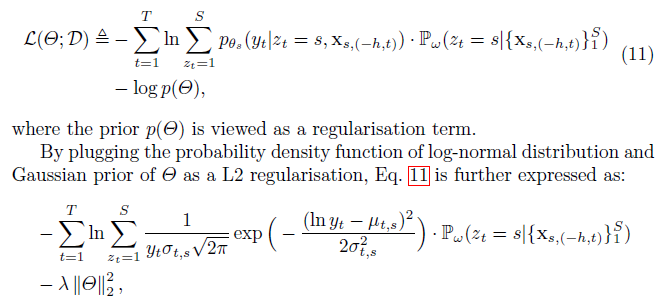

In [17]:
def tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=0.1):
    """
    Implements:
        -ln ∑_s [ lognormal(y_t | μ_s, σ_s^2) * P(z_t = s | x) ] + λ * ||θ||^2
    """

    eps = 1e-8  # for numerical stability
    log_y = torch.log(y + eps)

    # Log-normal density terms (not in log-space)
    def lognormal_pdf(y, log_y, mu, var):
        coef = 1.0 / (y * torch.sqrt(2 * torch.pi * var + eps))
        exponent = torch.exp(- (log_y - mu) ** 2 / (2 * var + eps))
        return coef * exponent

    p1 = lognormal_pdf(y, log_y, mu1, var1)
    p2 = lognormal_pdf(y, log_y, mu2, var2)

    # Combine with selector probabilities
    # print(probs[:,1])
    weighted_sum = probs[:,0] * p1 + probs[:,1] * p2

    # Negative log-likelihood (mean over batch)
    nll = -torch.log(weighted_sum + eps).mean() #maybe mean or sum

    # L2 Regularization (Gaussian prior on θ)
    l2_penalty = sum((p**2).sum() for p in model.parameters())
    reg = l2_lambda * l2_penalty

    return nll + reg


def train_tme_model(model, train_loader, val_loader, lr=5e-4, weight_decay=0.1, l2_lambda=0.1,
                    max_epochs=100, patience=10, device='cpu'):
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, weight_decay=0.1)#, momentum=0.9)


    best_val_loss = float('inf')
    best_state_dict = None
    patience_counter = 0
    
    for epoch in range(max_epochs):
        model.train()
        train_losses = []

        for x1, x2, y in train_loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)

            optimizer.zero_grad()

            final_pred, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

            loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())

        # Validation loss
        model.eval()
        val_losses = []

        with torch.no_grad():
            for x1, x2, y in val_loader:
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)

                final_pred, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

                val_loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
                val_losses.append(val_loss.item())

        avg_val_loss = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}, Train Loss: {sum(train_losses)/len(train_losses):.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_state_dict)
    return model, best_val_loss


def train_tme_ensemble(train_loader, val_loader, d1, d2, h, num_models=20, device='cpu', **train_kwargs):
    ensemble = []
    val_losses = []

    for i in range(num_models):
        print(f"\n🌱 Training ensemble model {i + 1}/{num_models}")

        # Set seed for reproducibility
        torch.manual_seed(i)
        model = TME(d1, d2, h)  # Initialize new model

        # Train the model using your function
        trained_model, best_val_loss = train_tme_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            **train_kwargs
        )

        # Save the model and its validation loss
        ensemble.append(trained_model)
        val_losses.append(best_val_loss)

    return ensemble, val_losses



In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ensemble, losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=source1_tensor.shape[1],  # number of features of the 1st source
    d2=source2_tensor.shape[1],  # number of features of the 2nd source
    h=source1_tensor.shape[2],  # lag length
    num_models=3,#20,
    device=device,
    lr=1e-3,
    weight_decay=0.1,
    l2_lambda=1,
    max_epochs=50,
    patience=5
)




🌱 Training ensemble model 1/3
Epoch 1, Train Loss: 31.1933, Val Loss: 25.6369
Epoch 2, Train Loss: 22.0260, Val Loss: 19.3817
Epoch 3, Train Loss: 18.6169, Val Loss: 18.4217
Epoch 4, Train Loss: 3.5777, Val Loss: 2.6434
Epoch 5, Train Loss: 1.0906, Val Loss: 1.3809
Epoch 6, Train Loss: 1.0815, Val Loss: 1.6972
Epoch 7, Train Loss: 1.0792, Val Loss: 0.2986
Epoch 8, Train Loss: 1.0946, Val Loss: 2.2274
Epoch 9, Train Loss: 1.0909, Val Loss: 2.1663
Epoch 10, Train Loss: 1.0906, Val Loss: 0.2176
Epoch 11, Train Loss: 1.0802, Val Loss: 0.2843
Epoch 12, Train Loss: 1.0958, Val Loss: 2.1337
Epoch 13, Train Loss: 1.0872, Val Loss: 1.4062
Epoch 14, Train Loss: 1.0883, Val Loss: 2.3279
Epoch 15, Train Loss: 1.0789, Val Loss: 0.3527
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1, Train Loss: 13.9658, Val Loss: 9.6410
Epoch 2, Train Loss: 5.2097, Val Loss: 4.0032
Epoch 3, Train Loss: 2.0069, Val Loss: 2.8925
Epoch 4, Train Loss: 1.5886, Val Loss: 0.2380
Epoch 5, Train Loss: 1.07

In [20]:
def evaluate_tme_ensemble(ensemble, test_loader, device='cpu'):
    all_preds = []
    y_trues = []

    with torch.no_grad():
        for x1, x2, y in test_loader:
            x1, x2, y = x1.to(device).to(torch.float64), x2.to(device).to(torch.float64), y.to(device).to(torch.float64)
            batch_preds = []

            for model in ensemble:
                model.eval()
                model.to(device).to(torch.float64)
                pred = model(x1, x2)
                batch_preds.append(pred.cpu())

            # Average predictions from all models
            avg_pred = torch.stack(batch_preds).mean(dim=0)
            all_preds.append(avg_pred)
            y_trues.append(y.cpu())

    y_preds = torch.cat(all_preds).numpy()
    y_trues = torch.cat(y_trues).numpy()

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    mae = mean_absolute_error(y_trues, y_preds)

    print(f"📊 Ensemble Test RMSE: {rmse:.4f}")
    print(f"📊 Ensemble Test MAE: {mae:.4f}")
    return rmse, mae


evaluate_tme_ensemble(ensemble, test_loader, device='cpu')


📊 Ensemble Test RMSE: 130.2084
📊 Ensemble Test MAE: 12.5614


(np.float64(130.2083840495494), 12.561444372301564)

Some things to consider:  
    
    - Model training takes a long time (full 20 model ensemble took me more than 3 hours)  
    - For hyperparams tuning we may use the smaller ensemble  
    - Adam vs SGD?  
    - Now I am clamping the values of the predicted variances and means when training and predicting (to avoid numerical blow up)  
    - The RMSE and MAE I got are reasonable (they are not extremely different). This is just an indication that probably the calculations are doing what they are supposed to do.